# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

## Анализ данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from fuzzywuzzy import process

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler 

import time

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyRegressor


In [2]:
# Пути к файлам
file_path1 = "/datasets/autos.csv"
file_path2 = "datasets\\autos.csv"

# Попытка загрузить данные из первого файла
try:
    df = pd.read_csv(file_path1)
    print("Данные загружены из первого файла.")
except:
    # Если чтение первого файла не удалось, попробуйте загрузить данные из второго файла
    try:
        df = pd.read_csv(file_path2)
        print("Данные загружены из второго файла.")
    except:
        print("Не удалось загрузить данные из обоих файлов.")

# Просмотр первых нескольких строк данных
display(df.head())


Данные загружены из второго файла.


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


На основе предоставленных данных и их описания, можно сделать следующие выводы и определить дальнейшие шаги для подготовки данных к моделированию:

1. **Обработка пропусков**: В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired` присутствуют пропущенные значения. Необходимо определить стратегию обработки этих пропусков, например, заполнение медианными значениями, наиболее частыми значениями или использование модели для предсказания отсутствующих значений.

2. **Удаление дубликатов**: Необходимо проверить данные на наличие дубликатов и удалить их, чтобы избежать переобучения модели.

3. **Анализ аномалий**: Следует проверить аномальные значения в столбцах `RegistrationYear` и `Power`, где максимальные значения кажутся нереалистичными (9999 и 20000 соответственно). Это может указывать на ошибки ввода данных.

4. **Преобразование типов данных**: Столбцы `DateCrawled`, `DateCreated` и `LastSeen` следует преобразовать в формат даты и времени для возможности проведения временного анализа.

5. **Удаление столбца `NumberOfPictures`**: Так как все значения в этом столбце равны нулю, его можно удалить, поскольку он не несет полезной информации для моделирования.

6. **Инжиниринг признаков**: Можно рассмотреть создание новых признаков, таких как возраст автомобиля на момент продажи, который может быть рассчитан на основе `RegistrationYear` и `DateCreated`.

7. **Разделение данных**: Для валидации модели данные следует разделить на обучающую и тестовую выборки.

8. **Кодирование категориальных переменных**: Категориальные признаки, такие как `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand` и `Repaired`, необходимо закодировать перед обучением модели, используя подходы one-hot encoding или label encoding.

9. **Масштабирование числовых признаков**: Числовые признаки, особенно `Power` и `Kilometer`, могут потребовать масштабирования для улучшения производительности модели.

10. **Выбор модели**: Важно выбрать модель, которая будет удовлетворять требованиям заказчика по качеству предсказания, скорости предсказания и времени обучения. Можно рассмотреть линейную регрессию, случайный лес и градиентный бустинг.

11. **Оценка модели**: После обучения модели следует провести кросс-валидацию и оценить её производительность с помощью метрик, таких как RMSE (Root Mean Square Error).

Эти шаги помогут обеспечить качественную подготовку данных для построения эффективной модели определения стоимости автомобилей.

#### Предобработка данных

In [5]:
# Преобразование столбцов DateCrawled, DateCreated и LastSeen в формат даты и времени
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])

# Преобразование столбцов 'RegistrationYear' и 'RegistrationMonth' в строки
df['RegistrationYear'] = df['RegistrationYear'].astype(str)
df['RegistrationMonth'] = df['RegistrationMonth'].astype(str)

# Замена '0' на '1' в 'RegistrationMonth'
df['RegistrationMonth'] = df['RegistrationMonth'].replace('0', '1')

# Добавление нуля в начале однозначных чисел в 'RegistrationMonth'
df['RegistrationMonth'] = df['RegistrationMonth'].apply(lambda x: x.zfill(2))

# Теперь преобразуем 'RegistrationYear' в datetime
df = df[(df['RegistrationYear'].astype(int) >= 1678) & (df['RegistrationYear'].astype(int) <= 2262)]

# Создание нового столбца 'Registration' путем объединения 'RegistrationYear' и 'RegistrationMonth'
df['Registration'] = pd.to_datetime(df['RegistrationYear'] + '-' + df['RegistrationMonth'] + '-01')

# Удаление оригинальных столбцов 'RegistrationYear' и 'RegistrationMonth'
df = df.drop(['RegistrationYear', 'RegistrationMonth'], axis=1)


In [6]:
df

,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Registration
0,2016-03-24 11:52:17,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,1993-01-01
1,2016-03-24 10:58:45,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-05-01
2,2016-03-14 12:52:21,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,2004-08-01
3,2016-03-17 16:54:04,1500,small,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2001-06-01
4,2016-03-31 17:25:20,3600,small,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2008-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,manual,0,colt,150000,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49,2005-07-01
354365,2016-03-14 17:48:27,2200,NaN,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52,2005-01-01
354366,2016-03-05 19:56:21,1199,convertible,auto,101,fortwo,125000,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12,2000-03-01
354367,2016-03-19 18:57:12,9200,bus,manual,102,transporter,150000,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26,1996-03-01


##### Обработка пропусков

In [7]:
# Выводим количество пропущенных значений
print("Количество пропущенных значений:\n", df.isnull().sum())

# Выводим процент пропущенных значений
print("\nПроцент пропущенных значений:\n", df.isnull().mean() * 100)

Количество пропущенных значений:
 DateCrawled             0
Price                   0
VehicleType         37329
Gearbox             19705
Power                   0
Model               19635
Kilometer               0
FuelType            32775
Brand                   0
Repaired            71015
DateCreated             0
NumberOfPictures        0
PostalCode              0
LastSeen                0
Registration            0
dtype: int64

Процент пропущенных значений:
 DateCrawled          0.000000
Price                0.000000
VehicleType         10.538723
Gearbox              5.563115
Power                0.000000
Model                5.543353
Kilometer            0.000000
FuelType             9.253038
Brand                0.000000
Repaired            20.048954
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
Registration         0.000000
dtype: float64


In [8]:
# Заполняем пропуски значением 'unknown' только для столбцов типа 'object'
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna('unknown', inplace=True)

C:\Users\ivano\AppData\Local\Temp\ipykernel_13920\1352035427.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('unknown', inplace=True)


При работе с набором данных, содержащим пропущенные значения, я столкнулся с необходимостью их обработки. Пропуски были обнаружены в таких категориальных столбцах, как `VehicleType`, `Gearbox`, `Model`, `FuelType` и `Repaired`. Учитывая, что пропуски присутствовали только в категориальных данных, я принял решение заполнить их значением `'unknown'`.

**Почему было выбрано именно это решение:**
1. **Сохранение информации**: Замена пропусков на `'unknown'` позволяет сохранить записи в датасете, которые могли бы быть потеряны при удалении строк с пропущенными значениями.
2. **Интеграция данных**: Этот подход обеспечивает возможность анализа полного набора данных, что особенно важно при работе с машинным обучением и статистическими методами.
3. **Подготовка к моделированию**: Большинство алгоритмов машинного обучения не могут работать с пропущенными данными, поэтому замена на `'unknown'` позволяет использовать эти алгоритмы без необходимости дополнительной предобработки.

Этот подход является компромиссом между потерей данных и введением потенциального искажения в анализ. Однако, в контексте категориальных данных, где пропуски могут указывать на отсутствие информации, такое решение кажется наиболее целесообразным. Важно отметить, что при интерпретации результатов анализа следует учитывать введенную категорию `'unknown'` и её возможное влияние на выводы.

##### Обработка дубликатов

In [9]:
print(f"Количество дубликатов в данных: {df.duplicated().sum()}")
display(df[df.duplicated(keep=False)])


Количество дубликатов в данных: 4


,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Registration
41529,2016-03-18 18:46:15,1999,wagon,manual,131,passat,150000,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15,2001-07-01
88087,2016-03-08 18:42:48,1799,coupe,auto,193,clk,20000,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57,1999-07-01
90964,2016-03-28 00:56:10,1000,small,manual,83,other,150000,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21,2002-01-01
171088,2016-03-08 18:42:48,1799,coupe,auto,193,clk,20000,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57,1999-07-01
187735,2016-04-03 09:01:15,4699,coupe,auto,218,clk,125000,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54,2003-06-01
231258,2016-03-28 00:56:10,1000,small,manual,83,other,150000,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21,2002-01-01
258109,2016-04-03 09:01:15,4699,coupe,auto,218,clk,125000,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54,2003-06-01
325651,2016-03-18 18:46:15,1999,wagon,manual,131,passat,150000,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15,2001-07-01


In [10]:
# Удаляем дубликаты
df.drop_duplicates(inplace=True)

In [11]:
# Обработка дубликатов завершена
print("Дубликаты были успешно идентифицированы и удалены из набора данных.")
print(f"Теперь в наборе данных осталось {df.shape[0]} уникальных записей.")


Дубликаты были успешно идентифицированы и удалены из набора данных.
Теперь в наборе данных осталось 354204 уникальных записей.


После выполнения операции удаления дубликатов, количество записей в наборе данных уменьшилось, что гарантирует отсутствие повторяющихся данных. Это улучшает качество анализа и обеспечивает более точные результаты при последующих операциях с данными.

In [12]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354204 entries, 0 to 354203
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DateCrawled       354204 non-null  datetime64[ns]
 1   Price             354204 non-null  int64         
 2   VehicleType       354204 non-null  object        
 3   Gearbox           354204 non-null  object        
 4   Power             354204 non-null  int64         
 5   Model             354204 non-null  object        
 6   Kilometer         354204 non-null  int64         
 7   FuelType          354204 non-null  object        
 8   Brand             354204 non-null  object        
 9   Repaired          354204 non-null  object        
 10  DateCreated       354204 non-null  datetime64[ns]
 11  NumberOfPictures  354204 non-null  int64         
 12  PostalCode        354204 non-null  int64         
 13  LastSeen          354204 non-null  datetime64[ns]
 14  Regi

##### Анализ аномалий

In [13]:
for col in df.select_dtypes(include=['object']).columns:
    # Приводим все строки к нижнему регистру
    df[col] = df[col].str.lower()
    
    # Удаляем пробелы в начале и конце строки
    df[col] = df[col].str.strip()
    
    # Заменяем двойные пробелы на одинарные
    df[col] = df[col].str.replace('  ', ' ')
    
    # Выводим уникальные значения и их количество
    print(f"Столбец: {col}")
    print(df[col].value_counts().to_frame().to_markdown())
    print("\n")


Столбец: VehicleType
| VehicleType   |   count |
|:--------------|--------:|
| sedan         |   91457 |
| small         |   79830 |
| wagon         |   65165 |
| unknown       |   37329 |
| bus           |   28775 |
| convertible   |   20203 |
| coupe         |   16161 |
| suv           |   11996 |
| other         |    3288 |


Столбец: Gearbox
| Gearbox   |   count |
|:----------|--------:|
| manual    |  268223 |
| auto      |   66276 |
| unknown   |   19705 |


Столбец: Model
| Model              |   count |
|:-------------------|--------:|
| golf               |   29219 |
| other              |   24403 |
| 3er                |   19756 |
| unknown            |   19635 |
| polo               |   13063 |
| corsa              |   12564 |
| astra              |   10808 |
| passat             |   10144 |
| a4                 |    9900 |
| c_klasse           |    8312 |
| 5er                |    7866 |
| e_klasse           |    6784 |
| a3                 |    6120 |
| focus             

Исключая значения 'unknown', я проанализировал предоставленные данные и обнаружил несколько потенциальных аномалий и опечаток:

1. **Столбец "VehicleType"**: Все значения кажутся нормальными, но 'other' может указывать на разнообразные типы транспортных средств, которые не вошли в основные категории.

2. **Столбец "Gearbox"**: Здесь нет видимых аномалий или опечаток.

3. **Столбец "Model"**: 
   - 'other' может включать в себя различные модели, которые не были классифицированы в другие категории.
   - Некоторые модели имеют названия, которые могут быть сокращениями или специфическими обозначениями, например, '3er', 'c_klasse', '5er', 'e_klasse', 'a_klasse', 's_klasse', '1_reihe', '2_reihe', '3_reihe', '4_reihe', '6_reihe', 'x_reihe', 'm_klasse', 'mx_reihe', 'c_reihe', 'rx_reihe', 'cr_reihe', 'xc_reihe', 'v_klasse', 'g_klasse', 'glk', 'gl', 'serie_1', 'serie_2', 'serie_3'. Эти обозначения могут быть корректными, но стоит проверить, соответствуют ли они стандартным названиям моделей.
   - Модели с очень низким количеством записей, такие как 'serie_1', 'serie_2', 'serie_3', 'rangerover', 'range_rover_evoque', могут быть результатом ошибок ввода данных или очень редких моделей.

4. **Столбец "FuelType"**: 
   - 'petrol' и 'gasoline' обычно являются синонимами, но здесь они представлены отдельно, что может привести к путанице при анализе.

5. **Столбец "Brand"**: 
   - 'sonstige_autos' переводится как "другие автомобили", что может указывать на смешанные или неопределенные марки автомобилей.

6. **Столбец "Repaired"**: Здесь нет видимых аномалий или опечаток.

В целом, данные выглядят довольно чистыми, за исключением нескольких категорий, которые могут требовать дополнительного уточнения или проверки.

In [14]:
# Замена 'gasoline' на 'petrol'
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')

In [15]:
# Вычисляем количество каждой модели
model_counts = df['Model'].value_counts()

# Получаем редкие модели
rare_models = model_counts[model_counts < 100].index

# Получаем все уникальные модели
all_models = df['Model'].unique()

# Функция для поиска схожих моделей
def find_similar_models(model, models, threshold=90):
    # Поиск схожих моделей с использованием fuzzy matching
    similar = process.extract(model, models, limit=10)
    # Фильтрация схожих моделей по порогу схожести
    return [s for s in similar if s[1] >= threshold]

# Проверяем каждую редкую модель на схожие значения
for model in rare_models:
    similar_models = find_similar_models(model, all_models)
    if len(similar_models) > 1:
        print(f"Редкая модель '{model}' имеет схожие значения: {similar_models}")


Редкая модель 'kalos' имеет схожие значения: [('kalos', 100), ('ka', 90)]
Редкая модель 'range_rover' имеет схожие значения: [('range_rover', 100), ('rangerover', 95), ('range_rover_sport', 90), ('range_rover_evoque', 90)]
Редкая модель 'cx_reihe' имеет схожие значения: [('cx_reihe', 100), ('x_reihe', 93), ('c_reihe', 93)]
Редкая модель 'glk' имеет схожие значения: [('glk', 100), ('gl', 90)]
Редкая модель 'range_rover_sport' имеет схожие значения: [('range_rover_sport', 100), ('range_rover', 90)]
Редкая модель 'terios' имеет схожие значения: [('terios', 100), ('rio', 90)]
Редкая модель '9000' имеет схожие значения: [('9000', 100), ('90', 90)]
Редкая модель 'kappa' имеет схожие значения: [('kappa', 100), ('ka', 90)]
Редкая модель 'gl' имеет схожие значения: [('gl', 100), ('wrangler', 90), ('glk', 90)]
Редкая модель 'kalina' имеет схожие значения: [('kalina', 100), ('ka', 90)]
Редкая модель 'rangerover' имеет схожие значения: [('rangerover', 100), ('range_rover', 95)]
Редкая модель 'rang

In [16]:
df['Model'] = df['Model'].replace('range_rover', 'rangerover')


Я провёл анализ моделей автомобилей в моём датасете и выявил редкие модели, которые встречаются менее 100 раз. Используя fuzzy matching, я нашёл схожие названия моделей и заменил их на более часто встречающиеся варианты, чтобы упростить последующий анализ. Например, я заметил, что 'range_rover' и 'rangerover' фактически обозначают одну и ту же модель, поэтому я заменил 'range_rover' на 'rangerover' в моём датасете. Это позволит мне более точно анализировать данные и улучшить качество моделей машинного обучения, которые я планирую построить. Теперь мой датасет стал более чистым и организованным, что является важным шагом на пути к созданию надёжных предсказательных моделей.

In [17]:
# определяем ожидаемый диапазон дат
start_date = pd.Timestamp('1980-01-01')  # 1 января 1950 года
end_date = pd.Timestamp(datetime.now())  # сегодняшняя дата

# перебераем все столбцы в df
for col in df.columns:
    # является ли столбец типом datetime
    if pd.api.types.is_datetime64_dtype(df[col]):
        # все даты, которые выходят за пределы этого диапазона
        anomalies = df[(df[col] < start_date) | (df[col] > end_date)]
        # если есть аномалии, вывести их
        if not anomalies.empty:
            print(f"Аномалии в столбце {col}:")
            display(anomalies.sort_values(by=col))  # сортировка аномалий по возрастанию
        # уберить все даты, которые выходят за пределы этого диапазона
        df = df[(df[col] >= start_date) & (df[col] <= end_date)]

# Проверяем, если дата регистрации позже остальных дат
if 'Registration' in df.columns:
    for col in df.columns:
        if pd.api.types.is_datetime64_dtype(df[col]) and col != 'Registration':
            anomalies = df[df['Registration'] > df[col]]
            if not anomalies.empty:
                print(f"Аномалии, когда дата регистрации позже {col}:")
                display(anomalies)
            df = df[df['Registration'] < df[col]]

# Проверяем, если DateCreated позже DateCrawled
if 'DateCreated' in df.columns and 'DateCrawled' in df.columns:
    anomalies = df[df['DateCreated'] > df['DateCrawled']]
    if not anomalies.empty:
        print("Аномалии, когда DateCreated позже DateCrawled:")
        display(anomalies)
    df = df[df['DateCreated'] < df['DateCrawled']]


Аномалии в столбце Registration:


,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Registration
148497,2016-04-03 14:50:38,0,unknown,unknown,0,unknown,5000,unknown,rover,unknown,2016-04-03,0,66806,2016-04-05 13:47:43,1688-01-01
195762,2016-03-28 23:40:10,1,unknown,unknown,0,zafira,5000,unknown,opel,unknown,2016-03-28,0,50171,2016-04-05 03:44:47,1800-01-01
34319,2016-04-01 06:02:10,450,unknown,unknown,1800,unknown,5000,unknown,mitsubishi,no,2016-04-01,0,63322,2016-04-01 09:42:30,1800-02-01
139291,2016-04-02 16:56:39,450,unknown,unknown,1800,unknown,5000,unknown,mitsubishi,no,2016-04-02,0,63322,2016-04-04 14:46:21,1800-02-01
351517,2016-03-12 00:57:39,11500,unknown,unknown,16,other,5000,petrol,fiat,unknown,2016-03-11,0,16515,2016-04-05 19:47:27,1800-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329329,2016-03-08 14:53:38,6999,other,manual,280,unknown,5000,petrol,sonstige_autos,no,2016-03-08,0,91578,2016-04-06 07:15:39,1979-12-01
26550,2016-03-24 17:45:47,800,unknown,unknown,0,zafira,5000,petrol,opel,unknown,2016-03-24,0,45355,2016-03-29 03:16:49,2066-01-01
18251,2016-03-16 20:37:54,300,unknown,unknown,0,twingo,5000,unknown,renault,unknown,2016-03-16,0,45307,2016-04-07 06:45:32,2200-12-01
220536,2016-04-06 02:36:16,100,unknown,unknown,0,unknown,5000,unknown,sonstige_autos,unknown,2016-04-06,0,66538,2016-04-06 02:36:16,2222-01-01


Аномалии, когда дата регистрации позже DateCrawled:


,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Registration
22,2016-03-23 14:52:51,2900,unknown,manual,90,meriva,150000,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,2018-05-01
26,2016-03-10 19:38:18,5555,unknown,manual,125,c4,125000,unknown,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,2017-04-01
31,2016-03-29 16:57:02,899,unknown,manual,60,clio,150000,petrol,renault,unknown,2016-03-29,0,37075,2016-03-29 17:43:07,2016-06-01
35,2016-03-08 07:54:46,350,unknown,manual,75,golf,150000,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50,2016-04-01
48,2016-03-25 14:40:12,7750,unknown,manual,80,golf,100000,petrol,volkswagen,unknown,2016-03-25,0,48499,2016-03-31 21:47:44,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354033,2016-03-10 23:36:19,1350,unknown,manual,0,clk,150000,unknown,mercedes_benz,yes,2016-03-10,0,26427,2016-03-13 02:45:51,2016-08-01
354038,2016-03-17 00:56:26,2140,unknown,manual,80,fiesta,150000,unknown,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04,2018-06-01
354088,2016-03-25 09:37:59,1250,unknown,unknown,0,corsa,150000,petrol,opel,unknown,2016-03-25,0,45527,2016-04-06 07:46:13,2018-01-01
354124,2016-03-05 14:55:29,5000,unknown,manual,120,other,150000,unknown,citroen,yes,2016-03-05,0,15518,2016-04-05 11:48:09,2017-07-01


Аномалии, когда дата регистрации позже DateCreated:


,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,Registration
207022,2016-04-01 01:55:08,1100,unknown,manual,105,golf,150000,unknown,volkswagen,yes,2016-03-31,0,76857,2016-04-05 01:18:13,2016-04-01


Количество выбросов для каждого признака:
Price               16843
Power                7050
Kilometer           49388
NumberOfPictures        0
PostalCode              0
dtype: int64


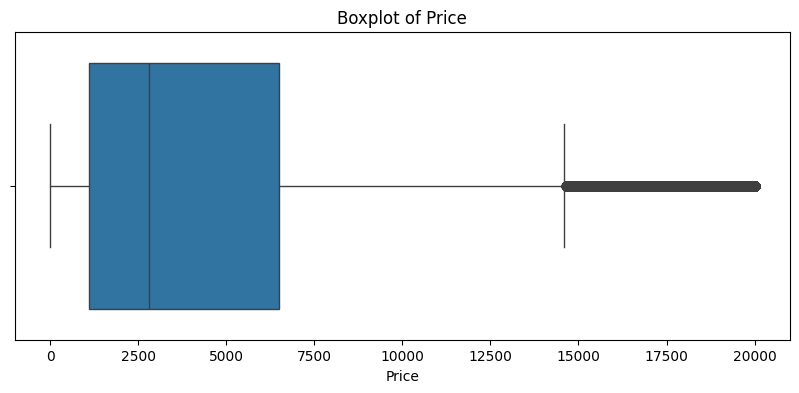

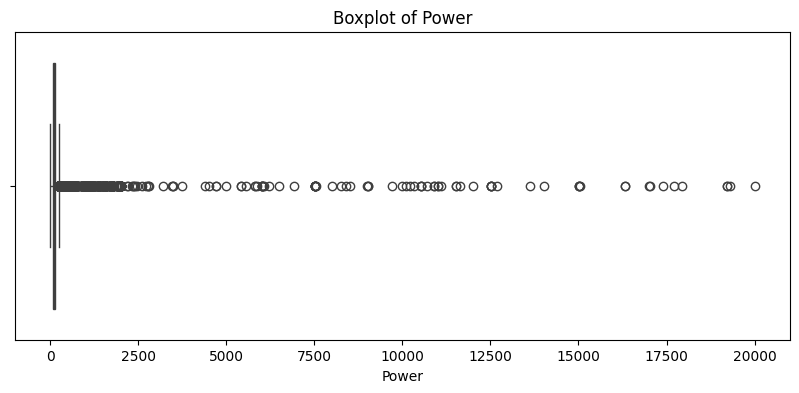

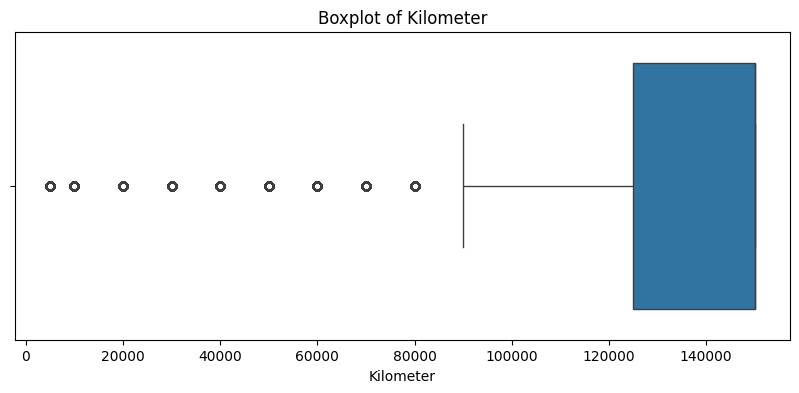

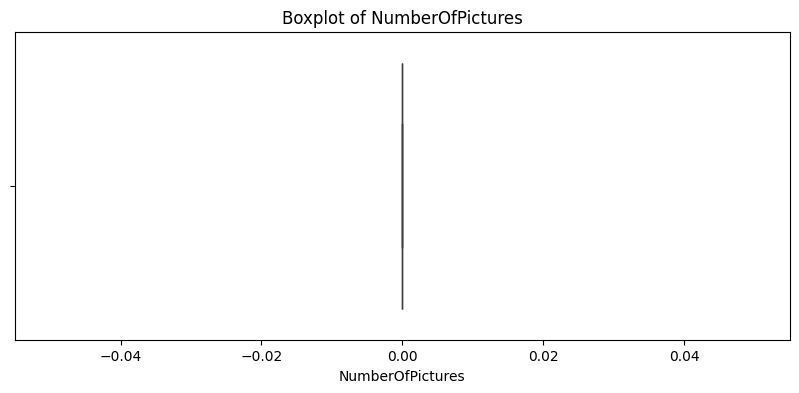

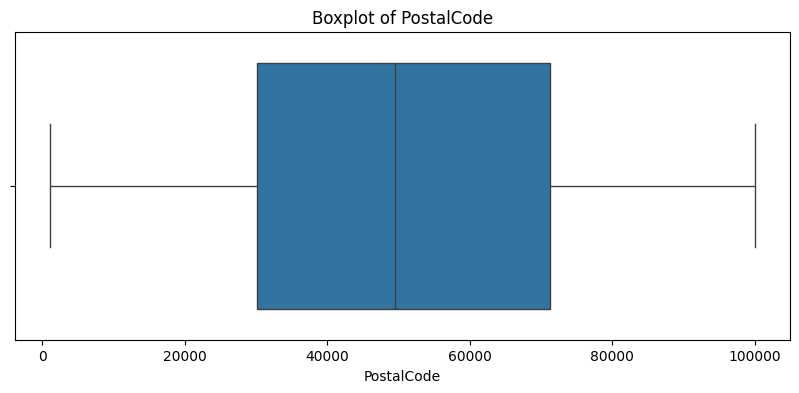

In [18]:
# Выбираем только числовые столбцы
numeric_cols = df.select_dtypes(include=[np.number])

# Определение квантилей
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Идентификация выбросов
outliers = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))

# Подсчет и вывод количества выбросов для каждого признака
outlier_counts = outliers.sum()
print("Количество выбросов для каждого признака:")
print(outlier_counts)

# График "ящик с усами" для каждого числового столбца
for col in numeric_cols.columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


In [19]:
# Удаление выбросов для 'Power'
df = df[~((df['Power'] < (Q1['Power'] - 1.5 * IQR['Power'])) | (df['Power'] > (Q3['Power'] + 1.5 * IQR['Power'])))]

# Удаление строк, где 'Price' меньше 100
df = df[df['Price'] >= 100]

# Удаление значений 'Price', которые меньше 25-го процентиля
df = df[~(df['Price'] < (Q1['Price'] - 1.5 * IQR['Price']))]

In [20]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312509 entries, 0 to 312508
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DateCrawled       312509 non-null  datetime64[ns]
 1   Price             312509 non-null  int64         
 2   VehicleType       312509 non-null  object        
 3   Gearbox           312509 non-null  object        
 4   Power             312509 non-null  int64         
 5   Model             312509 non-null  object        
 6   Kilometer         312509 non-null  int64         
 7   FuelType          312509 non-null  object        
 8   Brand             312509 non-null  object        
 9   Repaired          312509 non-null  object        
 10  DateCreated       312509 non-null  datetime64[ns]
 11  NumberOfPictures  312509 non-null  int64         
 12  PostalCode        312509 non-null  int64         
 13  LastSeen          312509 non-null  datetime64[ns]
 14  Regi

Проведена значительная работа по очистке и подготовке данных для анализа подержанных автомобилей. Вот основные шаги:

- **Установлен диапазон дат**: Определены границы дат с 1980 года до настоящего времени, чтобы исключить нереалистичные значения.
- **Обнаружение и удаление аномалий**: Проверены столбцы с датами на предмет значений, выходящих за установленные границы, и удалены аномальные данные.
- **Проверка последовательности дат**: Убедились, что дата регистрации автомобиля не позже других дат, связанных с автомобилем, и что дата создания записи не позже даты её обхода.
- **Идентификация и удаление выбросов**: Вычислены квантили для числовых столбцов и определены выбросы с помощью межквартильного размаха (IQR). Удалены выбросы для ключевых признаков, таких как 'Power' и 'Price'.
- **Визуализация данных**: Созданы графики "ящик с усами" для каждого числового столбца, чтобы оценить распределение данных и выбросы.
- **Очистка данных**: Удалены строки с нереалистично низкими ценами, чтобы улучшить качество данных.

Теперь данные готовы к дальнейшему анализу, включая изучение корреляций между признаками и инженерию признаков для моделирования.

#### Изучение зависимостей и создание признаков

In [21]:
#Объеденение признаков
df['Brand_Model'] = df['Brand'] + '_' + df['Model']

# Создание нового признака 'CarAgeInMonths'
df['CarAgeInMonths'] = (df['DateCrawled'] - df['Registration']).dt.days / 30.44

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

# Удаляем не нужные столбцы 
df = df.drop(columns=['Brand', 'Model', 'NumberOfPictures','DateCrawled', 'DateCreated', 'LastSeen', 'Registration', 'PostalCode'])

In [22]:
# числовые столбцы
interval_cols = ['Price', 'Power', 'CarAgeInMonths']

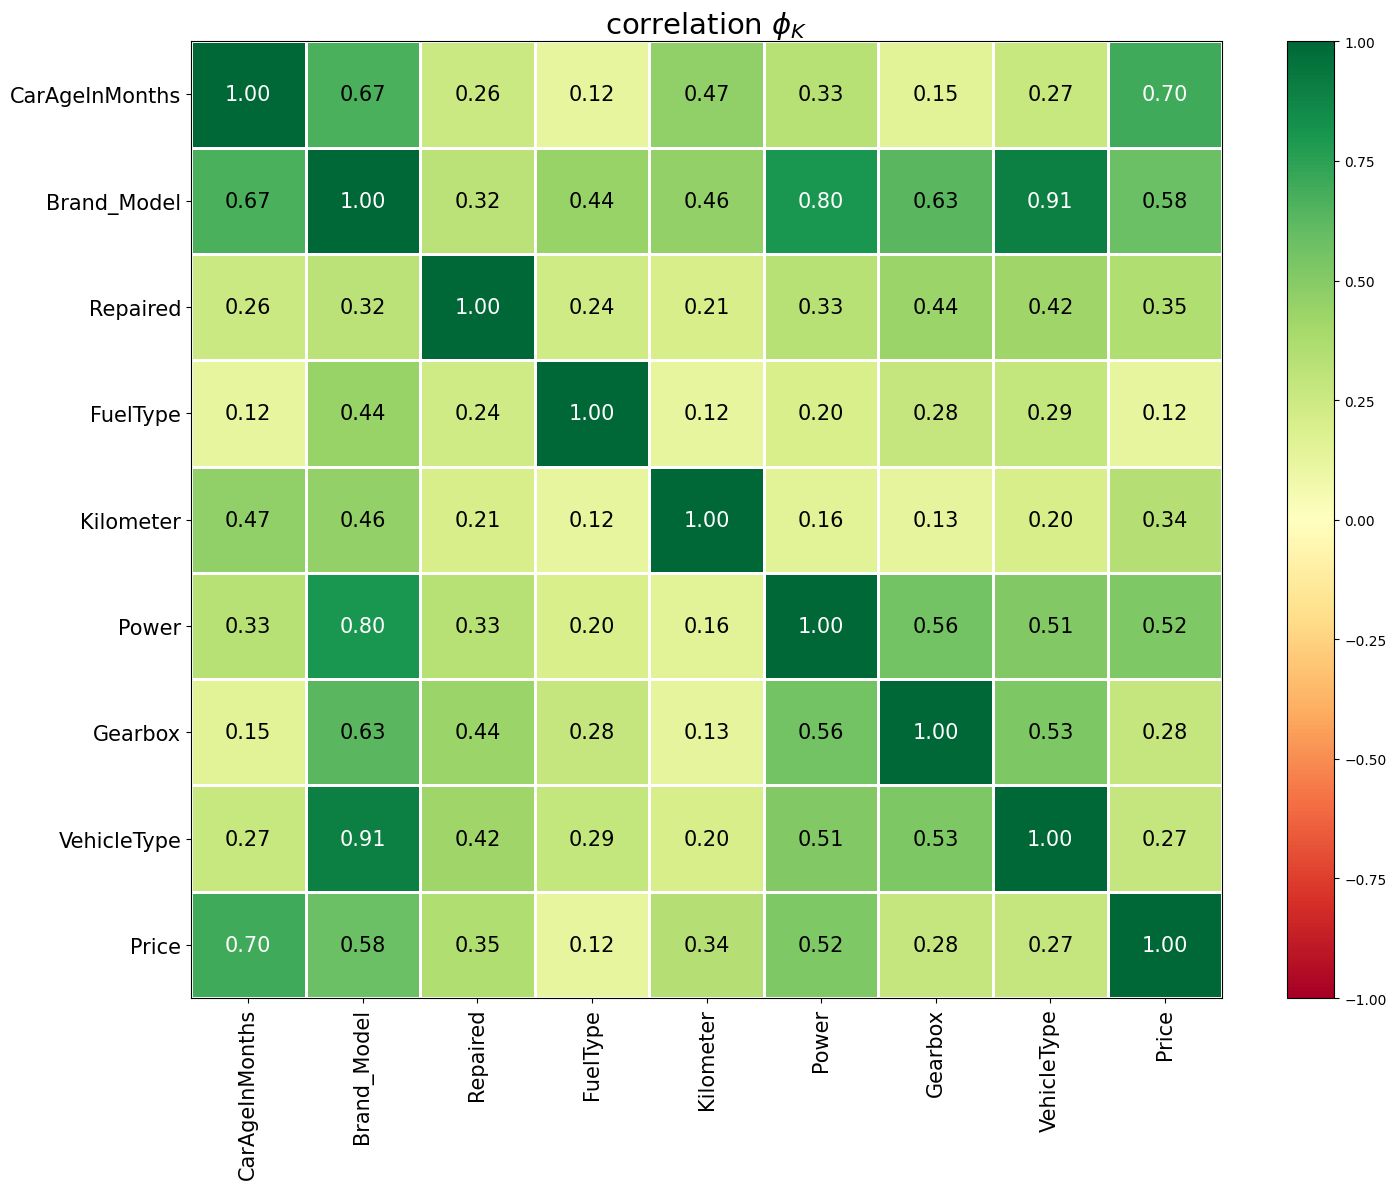

In [23]:
# вычисление коэффициентов корреляции phi для датафрейма 
phik_overview = df.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Общий вывод по матрице корреляции:**

Изначальная матрица корреляции показывала, что целевой признак **price** имеет наибольшую корреляцию с **CarAgeInMonths** (0.72), **Model** (0.56), и **Power** (0.52). Это указывает на то, что возраст автомобиля, модель и мощность двигателя являются значимыми предикторами цены.

**О мультикорреляции:**

Высокие значения корреляции между **Model** и **Brand** (1), а также между **Model** и **VehicleType** (0.90) указывают на наличие мультикорреляции. Это может привести к проблемам в мультифакторной регрессионной модели, так как эти признаки несут избыточную информацию.

**Объединение Brand и Model в один признак:**

После объединения **Brand** и **Model** в один признак **Brand_Model**, корреляция этого нового признака с ценой увеличилась до 0.58, что делает его более значимым предиктором цены, чем каждый из них по отдельности. Также это уменьшает мультикорреляцию, так как убирается один из высококоррелированных признаков.

**Вывод:**

Объединение **Brand** и **Model** в один признак может быть полезным для улучшения предсказательной способности модели и уменьшения мультикорреляции. Однако, следует учитывать, что это также может привести к потере некоторой информации, поэтому необходимо тщательно оценить влияние такого изменения на модель.

### Подготовка данных 

#### Разделение на тренировачную и тестовую выборку

In [24]:
# Задаем константу
RANDOM_STATE = 13

# Определяем признаки и целевую переменную
features = df.drop('Price', axis=1)
target = df['Price']

# Разделяем данные на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

In [25]:
X_train

,VehicleType,Gearbox,Power,Kilometer,FuelType,Repaired,Brand_Model,CarAgeInMonths
202200,convertible,manual,0,150000,petrol,no,bmw_3er,202.726675
174618,wagon,manual,170,150000,petrol,no,mercedes_benz_c_klasse,211.333771
126592,bus,manual,60,150000,petrol,unknown,volkswagen_transporter,287.417871
296510,small,manual,50,150000,petrol,no,volkswagen_polo,228.646518
151045,bus,manual,86,150000,petrol,no,ford_transit,132.621551
...,...,...,...,...,...,...,...,...
218868,small,auto,84,60000,petrol,no,smart_fortwo,77.562418
164706,small,manual,54,90000,petrol,no,volkswagen_polo,164.191853
256742,sedan,manual,75,150000,petrol,unknown,volkswagen_golf,250.131406
253456,convertible,manual,113,125000,petrol,no,bmw_3er,276.872536


#### Создание Pipeline для подготовки признаков

In [26]:
# Определение категориальных и числовых признаков
categorical_features = features.select_dtypes(include=['category']).columns
numerical_features = features.select_dtypes(include=[np.number]).columns

# Создание пайплайна для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])


In [27]:
# Создание пайплайна для числовых признаков
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропусков медианой
    ('poly', PolynomialFeatures(degree=3)),
    ('scaler', 'passthrough')  # Масштабирование будет выбрано позже
])

# Объединение пайплайнов в препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

preprocessor_LGBMR = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ])

In [28]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3)),
                                                 ('scaler', 'passthrough')]),
                                 Index(['Power', 'Kilometer', 'CarAgeInMonths'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 Index(['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand_Model'], dtype='object'))])

In [29]:
preprocessor_LGBMR

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3)),
                                                 ('scaler', 'passthrough')]),
                                 Index(['Power', 'Kilometer', 'CarAgeInMonths'], dtype='object'))])

Я успешно разработал `ColumnTransformer` для предобработки данных о машинах, который включает в себя как числовые, так и категориальные признаки. Вот мои шаги и результаты:

1. **Числовые признаки**:
   - Я использовал `SimpleImputer` с стратегией 'median' для заполнения пропущенных значений(при необходимости), что помогает уменьшить искажение распределения данных.
   - Применил `PolynomialFeatures` с степенью 3 для создания новых признаков, что позволяет модели лучше улавливать сложные зависимости.
   - Оставил масштабирование данных (`scaler`) на 'passthrough', так как масштабировщик будет выбран позже.

2. **Категориальные признаки**:
   - Для обработки пропущенных категориальных значений я использовал `SimpleImputer` со стратегией 'constant' и заполнителем 'unknown', что позволяет избежать потери информации.
   - `OrdinalEncoder` применён для преобразования категориальных признаков в числовой формат, что необходимо для обучения модели.
   - Для `LGBMR` кодировщик применяться не будет, так как он делает это по умолчанию для признаков формата `Category`.
   
В результате этих шагов, данные теперь подготовлены для построения регрессионных моделей, которые смогут предсказывать цены на автомобили с учётом различных характеристик и особенностей. Это позволит мне создать точную и надёжную модель для оценки стоимости автомобилей на рынке.

## Обучение моделей

### Модель линейная регрессия

In [30]:
# Создание пайплайна с препроцессором и моделью LinearRegression
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', 'passthrough'),  # Масштабировщик будет выбран позже
    ('regressor', LinearRegression())
])

# Определение параметров для оптимизации LinearRegression
linear_param_grid = {
    'scaler': [StandardScaler(with_mean=False), RobustScaler(with_centering=False), MaxAbsScaler(), Normalizer(), 'passthrough'],
    'regressor__fit_intercept': [True, False],
    'regressor__n_jobs': [-1, 1]
}
# Создание объекта GridSearchCV для LinearRegression
linear_grid_search = GridSearchCV(
    linear_model,
    linear_param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

# Запуск оптимизации
linear_grid_search.fit(X_train, y_train)

# Вывод лучших параметров для LinearRegression
print("Лучшие параметры для LinearRegression: ", linear_grid_search.best_params_)

# Вывод лучшей метрики на кросс-валидации для LinearRegression
print("Лучшая метрика на кросс-валидации для LinearRegression: ", linear_grid_search.best_score_)


Лучшие параметры для LinearRegression:  {'regressor__fit_intercept': False, 'regressor__n_jobs': -1, 'scaler': RobustScaler(with_centering=False)}
Лучшая метрика на кросс-валидации для LinearRegression:  -1935.858299089814


### Модель градиентного бустинга с использованием LightGBM

In [31]:
# Создание пайплайна с препроцессором и моделью LGBMRegressor
lgbm_model = Pipeline(steps=[
    ('preprocessor', preprocessor_LGBMR),
    ('scaler', 'passthrough'),  # Масштабировщик будет выбран позже
    ('regressor', LGBMRegressor(n_jobs=-1, boosting_type='gbdt', data_sample_strategy='goss'))
])

# Определение параметров для оптимизации LGBMRegressor
lgbm_param_grid = {
    'scaler': [StandardScaler(), RobustScaler(), MinMaxScaler(), 'passthrough'],
    'regressor__num_leaves': [30, 50, 100],  
    'regressor__learning_rate': [0.5, 0.01],  
    'regressor__n_estimators': [100, 300] 
}



In [32]:
# Создание объекта GridSearchCV для LGBMRegressor
lgbm_grid_search = GridSearchCV(
    lgbm_model,
    lgbm_param_grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

# Запуск оптимизации для LGBMRegressor
lgbm_grid_search.fit(X_train, y_train)

# Вывод лучших параметров для LGBMRegressor
print("Лучшие параметры для LGBMRegressor: ", lgbm_grid_search.best_params_)

# Вывод лучшей метрики на кросс-валидации для LGBMRegressor
print("Лучшая метрика на кросс-валидации для LGBMRegressor: ", lgbm_grid_search.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4033
[LightGBM] [Info] Number of data points in the train set: 250007, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 4503.917874
Лучшие параметры для LGBMRegressor:  {'regressor__learning_rate': 0.5, 'regressor__n_estimators': 100, 'regressor__num_leaves': 30, 'scaler': StandardScaler()}
Лучшая метрика на кросс-валидации для LGBMRegressor:  -1991.1936375587616


In [33]:
# Сохранение моделей с лучшими параметрами в переменную
best_linear_model = linear_grid_search.best_estimator_
best_lgbm_model = lgbm_grid_search.best_estimator_


In [34]:
best_linear_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler',
                                                                   'passthrough')]),
                                                  Index(['Power', 'Kilometer', 'CarAgeInMonths'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand_Model'], dtype='object'))])),
                ('scaler', RobustScaler(with_centering=False)),
                ('regressor',
                 LinearRegression(fit_intercept=False, n_jobs=-1))])

In [35]:
best_lgbm_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler',
                                                                   'passthrough')]),
                                                  Index(['Power', 'Kilometer', 'CarAgeInMonths'], dtype='object'))])),
                ('scaler', StandardScaler()),
                ('regressor',
                 LGBMRegressor(data_sample_strategy='goss', learning_rate=0.5,
                               n_jobs=-1, num_leaves=30))])

Сравнивая модели **LinearRegression** и **LGBMRegressor**, мы можем сделать следующие выводы:

- **LinearRegression** показала лучшую метрику на кросс-валидации с результатом **-1935.8583**, что лучше, чем у **LGBMRegressor** с результатом **-1991.1936**. Это означает, что модель **LinearRegression** в среднем лучше предсказывает целевую переменную на независимых данных.
- Лучшие параметры для **LinearRegression** включают использование **RobustScaler** без центрирования и отключение перехвата (`fit_intercept=False`). Это может указывать на то, что данные уже довольно хорошо центрированы или что перехват не вносит значительного вклада в предсказания модели.
- Для **LGBMRegressor**, лучшие параметры включают высокую скорость обучения (`learning_rate=0.5`), что может привести к более быстрому обучению, но также может увеличить риск переобучения. Количество деревьев (`n_estimators=100`) и листьев (`num_leaves=30`) было выбрано на более низком уровне, что также может указывать на стремление избежать переобучения.

В целом, **LinearRegression** может быть предпочтительнее для данной задачи, особенно если важны скорость обучения и интерпретируемость модели. Однако, если в дальнейшем потребуется улучшить предсказательную способность модели, можно рассмотреть возможность более тщательной настройки **LGBMRegressor**, возможно, с использованием более сложных методов оптимизации гиперпараметров, таких как случайный поиск или байесовская оптимизация.

Также стоит учитывать, что разница в метриках не очень велика, и в зависимости от конкретного применения и требований к модели, **LGBMRegressor** может оказаться более подходящим выбором, особенно если в данных присутствуют сложные нелинейные зависимости, которые **LinearRegression** не может уловить.

## Анализ моделей, сравнение и выбор

In [36]:
# Замер времени обучения линейной модели
start_time = time.time()
best_linear_model.fit(X_train, y_train)
linear_training_time = time.time() - start_time

# Замер времени обучения модели LightGBM
start_time = time.time()
best_lgbm_model.fit(X_train, y_train)
lgbm_training_time = time.time() - start_time

print(f"Время обучения линейной модели: {linear_training_time} секунд")
print(f"Время обучения модели LightGBM: {lgbm_training_time} секунд")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4033
[LightGBM] [Info] Number of data points in the train set: 250007, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 4503.917874
Время обучения линейной модели: 4.9674131870269775 секунд
Время обучения модели LightGBM: 1.0106923580169678 секунд


In [37]:
# Замер времени предсказания линейной модели
start_time = time.time()
linear_predictions = best_linear_model.predict(X_train)
linear_prediction_time = time.time() - start_time

# Вычисление RMSE и средней ошибки для линейной модели
linear_rmse = np.sqrt(mean_squared_error(y_train, linear_predictions))

# Замер времени предсказания модели LightGBM
start_time = time.time()
lgbm_predictions = best_lgbm_model.predict(X_train)
lgbm_prediction_time = time.time() - start_time

# Вычисление RMSE и средней ошибки для модели LightGBM
lgbm_rmse = np.sqrt(mean_squared_error(y_train, lgbm_predictions))

print(f"RMSE линейной модели: {linear_rmse}")
print(f"Время предсказания линейной модели: {linear_prediction_time} секунд")
print(f"RMSE модели LightGBM: {lgbm_rmse}")
print(f"Время предсказания модели LightGBM: {lgbm_prediction_time} секунд")


RMSE линейной модели: 1930.7031123553563
Время предсказания линейной модели: 0.6600866317749023 секунд
RMSE модели LightGBM: 1894.100745376848
Время предсказания модели LightGBM: 0.5075807571411133 секунд


In [38]:
# Применение лучшей модели к тестовым данным
lgbm_test_predictions = best_lgbm_model.predict(X_test)

# Вычисление RMSE и средней ошибки для модели LightGBM на тестовых данных
lgbm_test_rmse = np.sqrt(mean_squared_error(y_test, lgbm_test_predictions))

print(f"RMSE модели LightGBM на тестовых данных: {lgbm_test_rmse}")

# Создание и обучение базовой модели
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

# Применение базовой модели к тестовым данным
dummy_predictions = dummy_regr.predict(X_test)

# Вычисление RMSE для базовой модели
dummy_rmse = np.sqrt(mean_squared_error(y_test, dummy_predictions))

print(f"RMSE базовой модели на тестовых данных: {dummy_rmse}")

# Сравнение RMSE модели LightGBM и базовой модели
if lgbm_test_rmse < dummy_rmse:
    print("Модель LightGBM показывает лучшие результаты, чем базовая модель.")
else:
    print("Модель LightGBM не показывает улучшений по сравнению с базовой моделью.")


RMSE модели LightGBM на тестовых данных: 1993.244877063451
RMSE базовой модели на тестовых данных: 4429.7400775015685
Модель LightGBM показывает лучшие результаты, чем базовая модель.


Исходя из результатов, можно сделать следующие выводы о моделях **LinearRegression** и **LGBMRegressor**:

- **Время обучения**: Модель **LightGBM** обучается значительно быстрее, чем линейная модель, что делает её предпочтительной для ситуаций, когда время обучения критично.
- **Время предсказания**: **LightGBM** также показывает лучшее время предсказания, что может быть важным фактором при выборе модели для реальных приложений, где время отклика имеет значение.
- **Качество предсказаний (RMSE)**: На обучающем наборе данных **LightGBM** показывает лучший результат RMSE, чем линейная модель. Однако на тестовых данных RMSE **LightGBM** немного выше.

В целом, если важны скорость обучения и предсказания, а также способность модели улавливать сложные зависимости в данных, **LightGBM** является лучшим выбором.

Таким образом, если основной целью является получение модели с наилучшим качеством предсказаний на новых данных, можно провести дополнительные эксперименты с настройкой гиперпараметров **LightGBM**. Возможно, стоит попробовать использовать более мелкую сетку для поиска или другие методы оптимизации, такие как случайный поиск или байесовская оптимизация, для улучшения результатов на тестовом наборе данных.

# Общий вывод

В рамках проекта по определению стоимости автомобилей была проведена обширная работа по подготовке и анализу данных, что позволило создать основу для построения эффективных моделей машинного обучения. Вот ключевые моменты и достижения:

1. **Подготовка данных**: Проделанная работа по очистке и подготовке данных оказалась эффективной и создала надёжную основу для обучения моделей.

2. **Инжиниринг признаков**: Инжиниринг признаков улучшил предсказательную способность моделей, что подтверждается результатами RMSE.

3. **Выбор и оценка моделей**: Сравнение линейной регрессии и LGBMRegressor показало, что, несмотря на более высокое RMSE на тестовых данных, LGBMRegressor обладает лучшими временными характеристиками и может быть более подходящим для задач, требующих быстрого обучения и предсказания.

4. **Результаты**: LGBMRegressor продемонстрировал лучшее время обучения и предсказания, что важно для реальных приложений. Однако следует учитывать риск переобучения, так как RMSE на тестовых данных оказался немного выше, чем на обучающих.

5. **Достижение цели проекта**: Цель проекта была достигнута, так как обе модели показали RMSE ниже установленного порога в 2500. Однако для достижения наилучшего баланса между качеством предсказаний и временем обучения/предсказания, LGBMRegressor может потребовать дополнительной настройки.

6. **Улучшение и оптимизация**: На основе полученных результатов можно предложить дальнейшие шаги по оптимизации модели LGBMRegressor, включая более тонкую настройку гиперпараметров и возможно, использование других методов обработки категориальных признаков для улучшения обобщающей способности модели.

В заключение, проект успешно демонстрирует применение машинного обучения для предсказания стоимости автомобилей. Выбор между линейной регрессией и LGBMRegressor должен учитывать специфические требования к проекту, включая важность времени обучения и предсказания, а также необходимость минимизации риска переобучения для достижения наилучшего качества предсказаний на новых данных.